In [1]:
import os
import random, csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, metrics, optimizers, Sequential
from sklearn.utils import class_weight

tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

def load_csv(root, filename):
    #return seqs+scores from csv file
    if not os.path.exists(os.path.join(root, filename)):
        #if not exist, create
        seqwithscores = []
        for index in range(100, 170):
            with open(os.path.join(root, "rand_dna_seq_result_" + str(index) + ".csv"), 'r',encoding='utf-8-sig') as f_input:
                for line in f_input:
                    seqwithscores.append(line)
        #break up sequences
        random.shuffle(seqwithscores)
        #create csv file
        with open(os.path.join(root, filename), 'w', newline = '') as ex:
            writer = csv.writer(ex)
            for item in seqwithscores:
                writer.writerow(item)
                
    #csv file existing, read seqs+scores
    seqs, scores = [], []
    with open(os.path.join(root, filename)) as f:
        reader = csv.reader(f)
        for row in reader:
            score, seq = row[0], row[2:-1]
            score = int(score)
            seqs.append(seq)
            scores.append(score)
    return seqs, scores

def load_DNAScore(root, mode = 'train'):
    #read seqs+scores
    seqs, scores = load_csv(root, 'DNAScore.csv')
    #dataset division
    if mode == 'train':  # 60%
        seqs = seqs[:int(0.6 * len(seqs))]
        scores = scores[:int(0.6 * len(scores))]
    elif mode == 'val':  # 20% = 60%->80%
        seqs = seqs[int(0.6 * len(seqs)):int(0.8 * len(seqs))]
        scores = scores[int(0.6 * len(scores)):int(0.8 * len(scores))]
    else:  # 20% = 80%->100%
        seqs = seqs[int(0.8 * len(seqs)):]
        scores = scores[int(0.8 * len(scores)):]
    return seqs, scores


def base_to_vec(seq, pos):
    freq_A = round(seq.count('A') / len(seq), 2)
    freq_G = round(seq.count('G') / len(seq), 2)
    freq_C = round(seq.count('C') / len(seq), 2)
    freq_T = round(seq.count('T') / len(seq), 2)
    position = round(pos / len(seq), 2)
    if seq[pos] == 'A':
        return [freq_A, 0, 0, 0, 1, position]
    if seq[pos] == 'G':
        return [freq_G, 0, 0, 1, 0, position]
    if seq[pos] == 'C':
        return [freq_C, 0, 1, 0, 0, position]
    if seq[pos] == 'T':
        return [freq_T, 1, 0, 0, 0, position]
    else:
        return [0, 0, 0, 0, 0, 0]
    
def embedding(seqs):
    data = []
    for seq in seqs:
        data_seq = []
        for pos in range(len(seq)):
            data_seq.append(base_to_vec(seq, pos))
        data.append(data_seq)
    return data
            
batchsz = 128
max_review_len = 200
seqs_train, scores_train = load_DNAScore('dnascore', mode = 'train')
seqs_train = embedding(seqs_train)
scores_train = np.array(scores_train)
seqs_val, scores_val = load_DNAScore('dnascore', mode = 'val')
seqs_val = embedding(seqs_val)
scores_val = np.array(scores_val)
seqs_test, scores_test = load_DNAScore('dnascore', mode = 'test')
seqs_test = embedding(seqs_test)
scores_test = np.array(scores_test)

# specimen weights
# weights = class_weight.compute_class_weight('balanced',
#                                            np.unique(scores_train),
#                                            scores_train)
# class_weights = dict(zip([x for x in np.unique(scores_train)], weights.tolist()))
# print("weights:", class_weights)

# seqs_train:[b, 200]
# padding sequence to 200nt
seqs_train = keras.preprocessing.sequence.pad_sequences(seqs_train, maxlen=max_review_len, dtype='float32', padding = 'post')
seqs_val = keras.preprocessing.sequence.pad_sequences(seqs_val, maxlen=max_review_len, dtype='float32', padding = 'post')
seqs_test = keras.preprocessing.sequence.pad_sequences(seqs_test, maxlen=max_review_len, dtype='float32', padding = 'post')
#convert to tensor
seqs_train_tensor = tf.convert_to_tensor(seqs_train, dtype = tf.float32)
scores_train_tensor = tf.convert_to_tensor(scores_train, dtype = tf.int32)
scores_train_tensor = tf.one_hot(scores_train, depth = 10)

seqs_val_tensor = tf.convert_to_tensor(seqs_val, dtype = tf.float32)
scores_val_tensor = tf.convert_to_tensor(scores_val, dtype = tf.int32)
scores_val_tensor = tf.one_hot(scores_val, depth = 10)

seqs_test_tensor = tf.convert_to_tensor(seqs_test, dtype = tf.float32)
scores_test_tensor = tf.convert_to_tensor(scores_test, dtype = tf.int32)
scores_test_tensor = tf.one_hot(scores_test, depth = 10)
# 构建数据集，打散，批量，并丢掉最后一个不够batchsz的batch
db_train = tf.data.Dataset.from_tensor_slices((seqs_train_tensor, scores_train_tensor))
db_train = db_train.shuffle(1000).batch(batchsz, drop_remainder=True)
db_val = tf.data.Dataset.from_tensor_slices((seqs_val_tensor, scores_val_tensor))
db_val = db_val.batch(batchsz, drop_remainder=True)
db_test = tf.data.Dataset.from_tensor_slices((seqs_test_tensor, scores_test_tensor))
db_test = db_test.batch(batchsz, drop_remainder=True)
print('x_train shape:', seqs_train.shape, tf.reduce_max(scores_train), tf.reduce_min(scores_train))
print('x_val shape:', seqs_val.shape)
print('x_test shape:', seqs_test.shape)
print('y_train shape', scores_train.shape)

x_train shape: (42000, 200, 6) tf.Tensor(9, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)
x_val shape: (14000, 200, 6)
x_test shape: (14000, 200, 6)
y_train shape (42000,)


Epoch 1/100
328/328 [==============================] - 92s 230ms/step - loss: 2.0048 - accuracy: 0.4153 - acc_top2: 0.5955 - val_loss: 1.5219 - val_accuracy: 0.4539 - val_acc_top2: 0.6909
Epoch 2/100
328/328 [==============================] - 69s 209ms/step - loss: 1.6163 - accuracy: 0.4205 - acc_top2: 0.6651 - val_loss: 1.4764 - val_accuracy: 0.4538 - val_acc_top2: 0.6912
Epoch 3/100
328/328 [==============================] - 69s 209ms/step - loss: 1.5580 - accuracy: 0.4277 - acc_top2: 0.6772 - val_loss: 1.4607 - val_accuracy: 0.4538 - val_acc_top2: 0.6932
Epoch 4/100
328/328 [==============================] - 69s 210ms/step - loss: 1.5324 - accuracy: 0.4325 - acc_top2: 0.6838 - val_loss: 1.4547 - val_accuracy: 0.4538 - val_acc_top2: 0.6948
Epoch 5/100
328/328 [==============================] - 69s 210ms/step - loss: 1.5158 - accuracy: 0.4412 - acc_top2: 0.6821 - val_loss: 1.4488 - val_accuracy: 0.4537 - val_acc_top2: 0.6932
Epoch 6/100
328/328 [==============================] - 69s 2

328/328 [==============================] - 67s 206ms/step - loss: 1.4376 - accuracy: 0.4557 - acc_top2: 0.6985 - val_loss: 1.4295 - val_accuracy: 0.4538 - val_acc_top2: 0.6966
Epoch 88/100
328/328 [==============================] - 67s 206ms/step - loss: 1.4389 - accuracy: 0.4548 - acc_top2: 0.6982 - val_loss: 1.4290 - val_accuracy: 0.4538 - val_acc_top2: 0.6969
Epoch 89/100
328/328 [==============================] - 67s 205ms/step - loss: 1.4381 - accuracy: 0.4560 - acc_top2: 0.6978 - val_loss: 1.4277 - val_accuracy: 0.4539 - val_acc_top2: 0.6973
Epoch 90/100
328/328 [==============================] - 67s 205ms/step - loss: 1.4378 - accuracy: 0.4547 - acc_top2: 0.6996 - val_loss: 1.4280 - val_accuracy: 0.4538 - val_acc_top2: 0.6974
Epoch 91/100
328/328 [==============================] - 67s 205ms/step - loss: 1.4385 - accuracy: 0.4551 - acc_top2: 0.7004 - val_loss: 1.4295 - val_accuracy: 0.4539 - val_acc_top2: 0.6968
Epoch 92/100
328/328 [==============================] - 67s 205ms/st

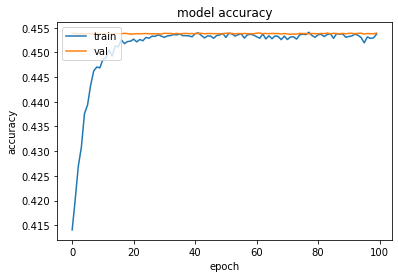

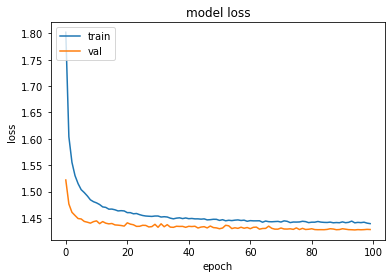

109/109 [==============================] - 6s 58ms/step - loss: 1.4365 - accuracy: 0.4490 - acc_top2: 0.7010
Model: "my_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            multiple                  0         
_________________________________________________________________
lstm_cell (LSTMCell)         multiple                  18176     
_________________________________________________________________
lstm_cell_1 (LSTMCell)       multiple                  33024     
_________________________________________________________________
sequential (Sequential)      (128, 10)                 4810      
Total params: 56,010
Trainable params: 56,010
Non-trainable params: 0
_________________________________________________________________
Save model!


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras import backend as K

class MyRNN(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyRNN, self).__init__() 
        # [b, 64]，构建Cell初始化状态向量，重复使用
        self.state0 = [tf.zeros([batchsz, units]),tf.zeros([batchsz, units])]
        self.state1 = [tf.zeros([batchsz, units]),tf.zeros([batchsz, units])]
        #masking
        self.masking = layers.Masking(mask_value=0, input_shape=(max_review_len,5))
        # 构建2个Cell
        self.rnn_cell0 = layers.LSTMCell(units, dropout=0.5)
        self.rnn_cell1 = layers.LSTMCell(units, dropout=0.5)
        # 构建分类网络，用于将CELL的输出特征进行分类，3分类
        # [b, 200, 5] => [b, 64] => [b, 10]
        self.outlayer = Sequential([
            layers.Dense(units),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(3)])

    def call(self, inputs, training=None):
        x = inputs # [b, 200，5]
        # masking
        x = self.masking(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        state0 = self.state0
        state1 = self.state1
        for word in tf.unstack(x, axis=1): # word: [b, 100] 
            out0, state0 = self.rnn_cell0(word, state0, training) 
            out1, state1 = self.rnn_cell1(out0, state1, training)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 3]
        out = self.outlayer(out1,training)

        return out
    
class Metrics(keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_x = self.validation_data[0]
        predict = self.model.predict(val_x)
        val_predict = np.argmax(predict, axis=-1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        
        seq_num = val_targ.shape[0]
        _val_f1 = f1_score(val_targ, val_predict[:4*seq_num:4], average='micro')
        _val_recall = recall_score(val_targ, val_predict[:4*seq_num:4], average='micro')
        _val_precision = precision_score(val_targ, val_predict[:4*seq_num:4], average='micro')
        
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precison: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

def acc_top2(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

units = 64 
epochs = 100 
    
model = MyRNN(units)
# compile
model.compile(optimizer = optimizers.Adam(0.0001),
              loss = losses.CategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy', acc_top2])
# train and validate
#history = model.fit(db_train, epochs=epochs, verbose=1, batch_size=batchsz,
#                    validation_data=db_train, callbacks=Metrics(valid_data=(seqs_val, scores_val)))
history = model.fit(db_train, epochs=epochs, verbose=1, batch_size=batchsz, validation_data=db_train)
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
model.evaluate(db_test)
model.summary()

#save model
model_path = r'./models/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
model.save_weights(os.path.join(model_path, 'DNA_Scoring_model_classfication_weights.h5'))
print("Save model!")

In [4]:
import h5py
from tensorflow import keras

class MyRNN(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyRNN, self).__init__() 
        # [b, 64]，构建Cell初始化状态向量，重复使用
        self.state0 = [tf.zeros([batchsz, units]),tf.zeros([batchsz, units])]
        self.state1 = [tf.zeros([batchsz, units]),tf.zeros([batchsz, units])]
        #masking
        self.masking = layers.Masking(mask_value=0, input_shape=(max_review_len,5))
        # 构建2个Cell
        self.rnn_cell0 = layers.LSTMCell(units, dropout=0.5)
        self.rnn_cell1 = layers.LSTMCell(units, dropout=0.5)
        # 构建分类网络，用于将CELL的输出特征进行分类，10分类
        # [b, 200, 5] => [b, 64] => [b, 10]
        self.outlayer = Sequential([
            layers.Dense(units),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(10)])

    def call(self, inputs, training=None):
        x = inputs # [b, 200，5]
        # masking
        x = self.masking(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        state0 = self.state0
        state1 = self.state1
        for word in tf.unstack(x, axis=1): # word: [b, 100] 
            out0, state0 = self.rnn_cell0(word, state0, training) 
            out1, state1 = self.rnn_cell1(out0, state1, training)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 10]
        out = self.outlayer(out1,training)

        return out

def acc_top2(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

#load model weights
units = 64
new_model = MyRNN(units)
# compile
new_model.compile(optimizer = optimizers.Adam(0.0001),
              loss = losses.CategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy', acc_top2])
new_model.fit(db_train)
model_path = r'./models/'
new_model.load_weights(os.path.join(model_path, 'DNA_Scoring_model_classfication_weights.h5'))
print('load model!')

285/285 [==============================] - 58s 148ms/step - loss: 1.9513 - accuracy: 0.4811 - acc_top2: 0.6574
load model!


In [ ]:
from tensorflow import keras

seqs, scores = [], []
with open(os.path.join('dnascore', "rand_dna_seq_result_100.csv"), 'r',encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    for row in reader:
        score, seq = row[0], row[1]
        scores.append(int(score))
        seqs.append(seq)

seqs = keras.preprocessing.sequence.pad_sequences(embedding(seqs), maxlen=max_review_len, dtype='float32', padding = 'post')
out = new_model.predict(seqs)
print(seqs.shape, out.shape)
out = np.argmax(out, axis = -1)
print(out)

In [96]:
type(scores_val)

numpy.ndarray

In [4]:
seqs_val.shape

(12200, 200, 6)

In [108]:
seqs_train[0]

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int32)

In [4]:
val_x_tensor = tf.convert_to_tensor(seqs_val, dtype = tf.float32)
val_x_tensor.shape

TensorShape([12200, 200, 6])